## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

import imageio
from skimage.transform import resize
from collections import Counter
from tqdm.notebook import tqdm

## Загрузка и подготовка датасета LFW

In [0]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[80%:]'],
)





## Информация о датасете

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

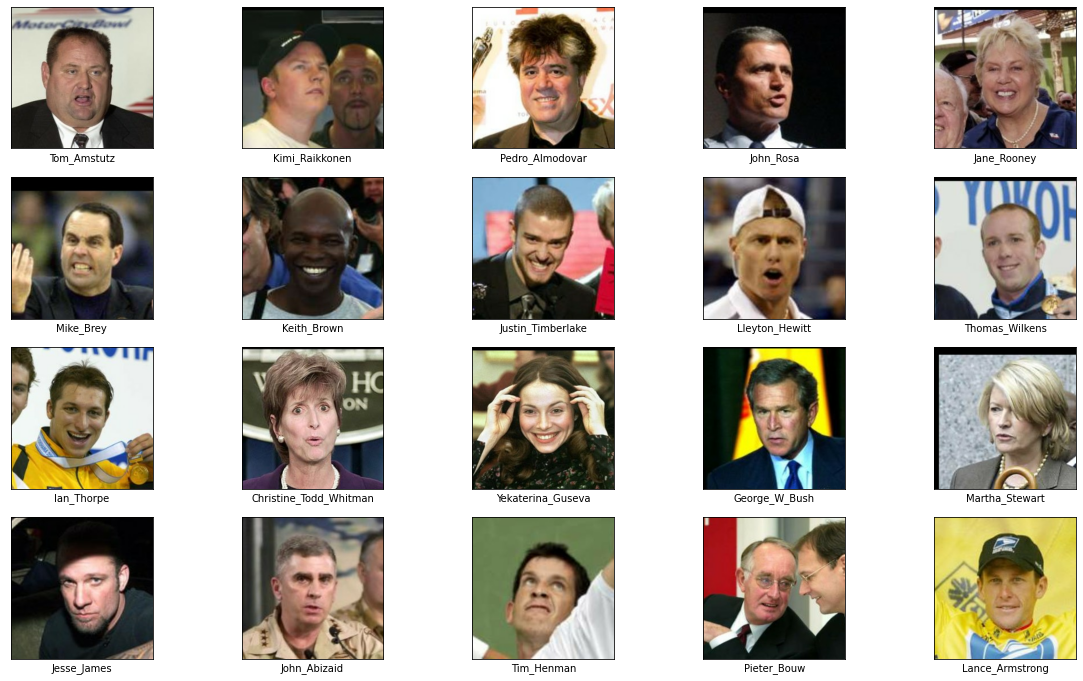

In [5]:
some_samples = [x for x in iter(train_ds.take(20))]

fig = plt.figure(figsize=(20, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 5, j+1)
    ax.imshow(some_samples[j][1])
    ax.set_xlabel(some_samples[j][0].numpy().decode())
    plt.xticks([]), plt.yticks([])
plt.show()


## Создание модели CNN

In [0]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])


## Contrastive Loss

In [0]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [0]:
N = 10
INP_SIZE = 250
BATCH_SIZE = 64
NUM_EPOCHS = 200

In [0]:
class SiameseNetworkDataset():
    
    '''Клас создания датасета для N лэйблов'''
    
    def __init__(self,train_ds=train_ds, N=N, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):        
        self.train_ds = train_ds 
        self.N = N
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_EPOCHS = NUM_EPOCHS

    def get_name(self, train_ds, N):
        #  Получени N имен с самым большим количиством изображений
        train_ds_shape = tf.data.experimental.cardinality(train_ds).numpy()
        names_list = [x[0].numpy().decode('utf-8') for x in iter(train_ds.take(train_ds_shape))]
        most_common_names = Counter(names_list).most_common(N)
        
        most_common_names_list = []
        for name in most_common_names:
            most_common_names_list.append(name[0])
            
            
        MAP_SET = {}
        for iterations, names in enumerate(most_common_names_list):
            MAP_SET[names] =  iterations
        return most_common_names, most_common_names_list, MAP_SET
    
    def get_data_name(self, train_ds, N):
        # Выбор из датасета фотографий согласно списку
        most_common_names, most_common_names_list, MAP_SET = self.get_name(train_ds, N)
        
        lst_train_ds = list(train_ds.as_numpy_iterator())
        new_dataset_list = []
        for examples in tqdm(lst_train_ds):
            if examples[0].decode('utf8') in most_common_names_list:
                new_dataset_list.append(examples)
                
        for n in tqdm(range(len(new_dataset_list))):
            new_dataset_list[n] = list(new_dataset_list[n])
            new_dataset_list[n][0] = np.array(MAP_SET[new_dataset_list[n][0].decode('utf8')])
                
        train_x = new_dataset_list[0][1].reshape(-1, 250, 250, 3)
        train_y = [new_dataset_list[0][0]]
        for imgs in tqdm(new_dataset_list[1:]):
            train_x = np.vstack((train_x, imgs[1].reshape(-1, 250, 250, 3)))
            train_y.append(imgs[0])
        return train_x, train_y
            
            
    def dataset_processing(self, train_ds, N, BATCH_SIZE, NUM_EPOCHS):
        # Сборка датасета
        train_x, train_y = self.get_data_name(train_ds, N)
        
        train_y = np.array(train_y)
        train_x = train_x.astype(np.float32) / 255.
        
        train_df = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        train_df = train_df.shuffle(buffer_size=train_x.shape[0])
        train_df = train_df.repeat(NUM_EPOCHS)
        train_df = train_df.batch(BATCH_SIZE)
        
        return train_df, train_x, train_y

In [0]:
SND = SiameseNetworkDataset()

In [11]:
train_ds, train_x, train_y = SND.dataset_processing(train_ds, N, BATCH_SIZE, NUM_EPOCHS)

## Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [13]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))


[0] Loss: 64.00342559814453
[200] Loss: 10.075258255004883
[400] Loss: 12.564457893371582
[600] Loss: 6.287496566772461
[800] Loss: 2.2873544692993164
[1000] Loss: 3.641782760620117
[1200] Loss: 1.0429936647415161
[1400] Loss: 1.574616551399231
[1600] Loss: 0.5817540884017944
[1800] Loss: 0.2985658645629883
[2000] Loss: 0.12037535756826401
[2200] Loss: 0.39337441325187683
[2400] Loss: 0.1882205456495285
[2600] Loss: 0.12365317344665527
[2800] Loss: 0.10942737758159637
[3000] Loss: 0.10115961730480194
[3200] Loss: 0.12225145846605301
[3400] Loss: 0.2834045886993408
[3600] Loss: 0.2201850563287735
CPU times: user 5min 5s, sys: 1min 28s, total: 6min 34s
Wall time: 8min 2s


## Получение эмбеддингов для тестовой выборки

In [0]:
embs = model(train_x[:200])

## Функция для визуализации эмбеддингов

In [0]:


def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)



## Визуализация образцов LFW в 2D пространстве с помощью TSNE

In [0]:
test_x_flat = train_x.reshape(-1, 250*250*3)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:200])
labels_for_viz = train_y[:200]

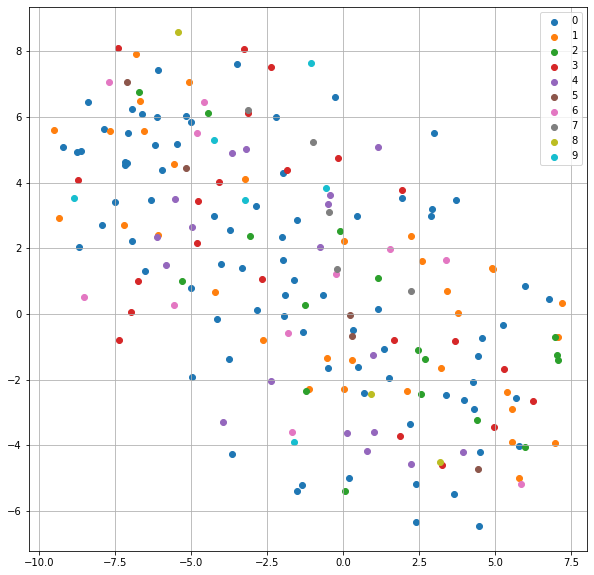

In [17]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(N)))


## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [0]:
test_embs_2D = TSNE(n_components=2).fit_transform(embs)
labels_for_viz = train_y[:200]



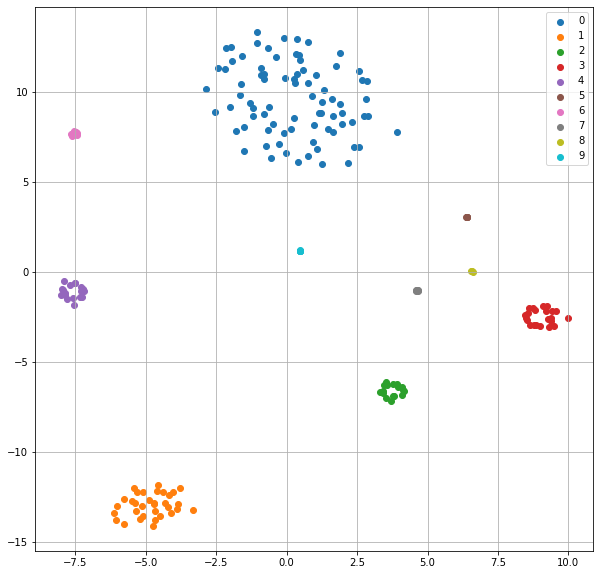

In [19]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(N)))

## Тестирование на новых данных

In [0]:
def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (INP_SIZE, INP_SIZE, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (INP_SIZE, INP_SIZE, 3))
    return img


# Среднеквадратичное расстояние между предиктами
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [0]:
img_AC = load_and_prepare_image('AC.png')
img_MA = load_and_prepare_image('MA.png')
img_MJ = load_and_prepare_image('MJ.png')
img_AC1 = load_and_prepare_image('AC1.png')
img_MA1 = load_and_prepare_image('MA1.png')
img_MJ1 = load_and_prepare_image('MJ1.png')

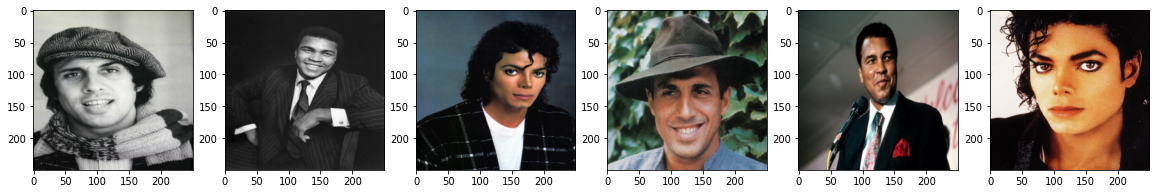

In [22]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 6, 1)
ax.imshow(img_AC)
ax = fig.add_subplot(1, 6, 2)
ax.imshow(img_MA)
ax = fig.add_subplot(1, 6, 3)
ax.imshow(img_MJ)
ax = fig.add_subplot(1, 6, 4)
ax.imshow(img_AC1)
ax = fig.add_subplot(1, 6, 5)
ax.imshow(img_MA1)
ax = fig.add_subplot(1, 6, 6)
ax.imshow(img_MJ1)


plt.show()

## Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_AC, img_MA, img_MJ, img_AC1, img_MA1, img_MJ1), axis=0))

## Вычисление расстояний между эмбеддингами

In [24]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #img_AC
emb2 = new_embs[1,:] #img_MA
emb3 = new_embs[2,:] #img_MJ
emb4 = new_embs[3,:] #img_AC1
emb5 = new_embs[4,:] #img_MA1
emb6 = new_embs[5,:] #img_MJ1

print('img_AC <-> img_MA: ', diff(emb1, emb2))
print('img_MA <-> img_MJ: ', diff(emb2, emb3))
print('img_AC <-> img_MJ: ', diff(emb1, emb3))
print('img_AC <-> img_AC1: ', diff(emb1, emb4))
print('img_MA <-> img_MA1: ', diff(emb2, emb5))
print('img_MJ <-> img_MJ1: ', diff(emb1, emb6))


img_AC <-> img_MA:  5.030971543087716
img_MA <-> img_MJ:  4.6905731299961415
img_AC <-> img_MJ:  3.6462314642643316
img_AC <-> img_AC1:  5.580449493515967
img_MA <-> img_MA1:  8.32263575252099
img_MJ <-> img_MJ1:  3.2937607361475583


В качестве новых данных загрузил по две фото трех известных персон. Разные фото одной персоны, модель расположила семантически далеко.